# Rag based on chunk summary

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from stringdale import V,E,Define,Condition,StructureJson
from stringdale.chat import Chat
from stringdale.db import ChromaClient

In [ ]:
client = ChromaClient()

## Upload Docs

Lets say we have a list of documents we want to base our RAG on.
The first step is to split them into chunks. Here is a basic example.

In [ ]:
sample_doc = {'text':"""
The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.

The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.

The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.
""",
'id':'animal_book'
}

In [ ]:
def splitter(doc):
    doc_id = doc['id']
    text = doc['text']
    return [{'text':chunk.strip(),'id':f'{doc_id}_{i}'} for i,chunk in enumerate(text.split('\n\n'))]

chunks = splitter(sample_doc)
chunks



[{'text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.',
  'id': 'animal_book_0'},
 {'text': 'The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.',
  'id': 'animal_book_1'},
 {'text': "The octopu

Now we would like to summarize each chunk.

In [ ]:
summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that summarizes chunks of text.
        Here are some examples of how to summarize text:
        Text:
        Dogs are loyal companions that come in many breeds. They are known for their intelligence, 
        trainability and ability to form strong bonds with humans. Dogs have been domesticated 
        for thousands of years and serve many roles including pets, working animals, and service animals.
        They communicate through barking, body language and facial expressions. Most dogs are social 
        animals that thrive on interaction with their human families.
        Summary:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'{{text}}'}
    ])

res = await summarizer(text=chunks[0]['text'])
res


{'role': 'assistant',
 'content': 'Description of elephants as intelligent and social creatures with strong family bonds and emotional behaviors.',
 'meta': {'input_tokens': 191, 'output_tokens': 16}}

After running the summarizer in its own node, we would get data that looks something like this.

In [ ]:
unstructured_summary = {
   'doc':{
      'text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.",
      'id': 'animal_book_2'
   },
   'summary': 'Description of elephants as intelligent and social animals.',
}

We would like to end up with chunks of the following shape:

In [ ]:
chunk_example = {
    'text': 'Here we put a summary of the text so we can index the chunk based on the summary',
    'id': 'doc_id',
    'metadata':{
        'full_text': '''
            Here we put the original text, so we can access it when we retrieve the chunk
            It is the full text that we would inject into the prompt
        '''
    }
}

Many API's require building nested objects from existing objects. To make this simpler, we made a utility that helps us build functions that take a bunch of input objects, and structure them into a nested object.

In [ ]:
from stringdale import StructureJson

In [ ]:
StructureJson('text=summary','id=doc.id','metadata.full_text=doc.text')(**unstructured_summary)

{'text': 'Description of elephants as intelligent and social animals.',
 'id': 'animal_book_2',
 'metadata': {'full_text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan."}}

Lets put it all together into a summarize chunk diagram.

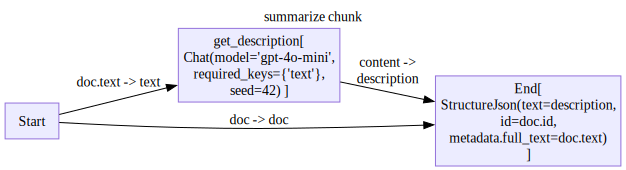

In [ ]:
with Define('summarize chunk',type='flow') as SummarizeChunk:
    V('get_description',summarizer,inputs=['Start(text=doc.text)'])
    V('End',StructureJson('text=description','id=doc.id','metadata.full_text=doc.text'),
        inputs=['Start(doc=doc)',
        'get_description(description=content)'
        ])
SummarizeChunk.draw()

Now we will build our RAG uploader diagram. For each text we will:
* split it into chunks
* summarize each chunk
* push them all to the db

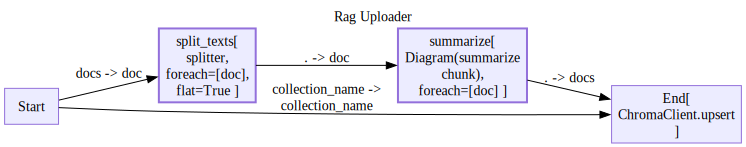

In [ ]:
# TODO consider adding zip to stringdale foreach syntax
with Define('Rag Uploader',type='flow') as RagUpload:
    V('split_texts',splitter,inputs=['Start(doc=docs)'],for_each=['doc'],flat=True)
    V('summarize',SummarizeChunk,
        inputs=['split_texts(doc=.)'],
        for_each=['doc'])
    V('End',client.upsert,inputs=['summarize(docs)','Start(collection_name=collection_name)'])

RagUpload.draw()


In [ ]:
client.add_collection("animal_book",exists_ok=True)
d = RagUpload()
for trace in d.run({'docs':[sample_doc],'collection_name':'animal_book'}):
    # trace.pprint()
    pass

d.output


[{'text': 'Description of the arctic fox and its adaptations to cold environments.',
  'id': 'animal_book_1',
  'metadata': {'full_text': 'The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.'}},
 {'text': 'Overview of octopuses as highly intelligent invertebrates with unique abilities.',
  'id': 'animal_book_2',
  'metadata': {'full_text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their rem

## RAG

Now we can query our db, but we have to make sure that we convey our query into a chunk summary, so that we get relevant chunks from our document.

In [ ]:
guess_summary = topic_summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that predicts what kind of summaries will be helpful for a given query.
        Here are some examples:
        query:
        I have an elephant and a dog. What is the most important thing about them?
        Summaries:
        Descriptions of elephants.
        Descriptions of dogs.
        query:
        What is the most important thing about elephants?
        Summaries:
        Descriptions of elephants.
        query:
        What is the most important thing about dogs?
        Summaries:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'query:{{query}}'},
        {'role':'assistant','content':'summaries:'}

    ])

res = await guess_summary(query="I need help with my lion choco")
res

{'role': 'assistant',
 'content': 'Descriptions of lion choco (the chocolate snack).  \nTips for enjoying lion choco.  \nInformation about the ingredients and nutritional value of lion choco.  \nWays to incorporate lion choco in recipes or snacks.  ',
 'meta': {'input_tokens': 119, 'output_tokens': 44}}

Now we can build our RAG as usual. To make it more interesting, we will add some few-shot example on how we would like the chat to answer our queries.

In [ ]:
full_text_rag_prompt = [
            {'role':'system','content':'''
            You are a helpful assistant that answers questions about animals.

            Here are some examples of how to answer questions about animals:
            {% for example in examples %}
            Question: {{example['question']}}
            Answer: {{example['answer']}}
            {% endfor %}

            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['metadata']['full_text']}}
            {% endfor %}
            '''},
            {'role':'user','content':'{{input}}'},
            ]

style_examples = [
    {
        'question': "What are the key traits of Pandas?",
        'answer': """Here are the key traits of Pandas:

            • Pandas are a type of bear
            • They are native to South America
            • They are known for their black and white fur
            • They are known for their love of bamboo"""
    },
    {
        'question': "What are the key traits of Lions?",
        'answer': """Here are the key traits of Lions:
        
            • Lions are a type of bear
            • They are native to Africa
            • They are known for their mane of hair"""
    }
]

# note that we bake the example in to the prompt
# there fore we do not need to feed them to the node inside the diagram
few_shot_rag_chat = Chat(model='gpt-4o-mini',
    messages=full_text_rag_prompt,
    examples=style_examples 
    )
few_shot_rag_chat

Chat(model='gpt-4o-mini', required_keys={'docs', 'input'}, seed=42)

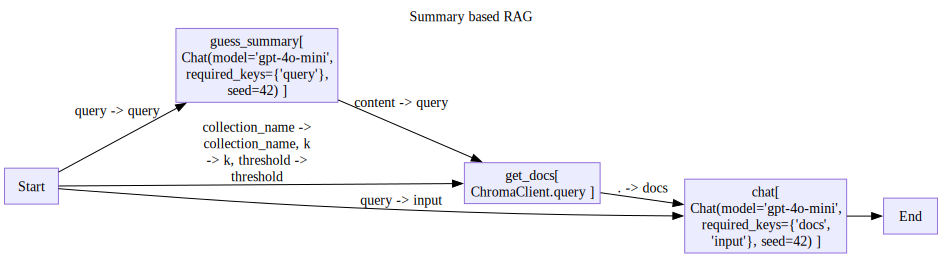

In [ ]:
with Define('Summary based RAG',type='flow') as SummaryRAG:
    V('guess_summary',guess_summary,
        inputs=['Start(query=query)'],
    )
    V('get_docs',client.query,
        inputs=['guess_summary(query=content)','Start(collection_name=collection_name,k=k,threshold=threshold)'],
    )
    V('chat',few_shot_rag_chat,
        inputs=['get_docs(docs)','Start(input=query)'],
        outputs=['End']
    )
SummaryRAG.draw()

In [ ]:
d=SummaryRAG()
for trace in d.run({'query':'I need help with my elephant choco','collection_name':'animal_book','k':2,'threshold':1}):
    trace.pprint(skip_passthrough=True)
print(d.output['content'])

Could you please clarify what you mean by "elephant choco"? Are you referring to a specific dessert, craft, or project involving elephants or chocolate?
